In [1]:
!pip install -r requirements.txt

In [2]:
# Basic image processing using OpenCV
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def generate_gaussian_pyramid(image, levels):
    """Generate Gaussian pyramid for an image."""
    gaussian_pyramid = [image]

    for _ in range(levels):
        image = cv2.pyrDown(image)
        gaussian_pyramid.append(image)

    return gaussian_pyramid

def laplacian_pyramid_blending(img1, img2, mask, levels=6):
    """Blend two images using Laplacian pyramid blending with a mask."""
    # Convert mask to float and resize
    mask = mask.astype(np.float32) / 255.0

    # Generate Gaussian pyramids
    gaussianA = generate_gaussian_pyramid(img1, levels)
    gaussianB = generate_gaussian_pyramid(img2, levels)
    gaussianMask = generate_gaussian_pyramid(mask, levels)

    # Generate Laplacian pyramids
    laplacianA = generate_laplacian_pyramid(gaussianA)
    laplacianB = generate_laplacian_pyramid(gaussianB)

    # Blend Laplacian pyramids
    blended_pyramid = blend_pyramids(laplacianA, laplacianB, gaussianMask)

    # Reconstruct final blended image
    blended_image = reconstruct_from_pyramid(blended_pyramid)

    return blended_image

def generate_laplacian_pyramid(gaussian_pyramid):
    """Generate Laplacian pyramid from a Gaussian pyramid."""
    laplacian_pyramid = []

    for i in range(len(gaussian_pyramid) - 1):
        dstsize = (gaussian_pyramid [i].shape [1], gaussian_pyramid [i].shape [0])

        upsampled = cv2.pyrUp(gaussian_pyramid [i + 1], dstsize=dstsize)
        laplacian = cv2.subtract(gaussian_pyramid[i], upsampled)

        laplacian_pyramid.append(laplacian)

    laplacian_pyramid.append(gaussian_pyramid[-1]) # Add the smallest level

    return laplacian_pyramid

def blend_pyramids(laplacianA, laplacianB, mask_pyramid):
    """Blend two Laplacian pyramids using a mask pyramid."""
    blended_pyramid = []

    for lapA, lapB, mask in zip(laplacianA, laplacianB, mask_pyramid) :
        blended = lapA * mask + lapB * (1 - mask)
        blended_pyramid.append(blended)

    return blended_pyramid

def reconstruct_from_pyramid(laplacian_pyramid):
    """Reconstruct image from a Laplacian pyramid."""
    image = laplacian_pyramid [-1]

    for i in range(len(laplacian_pyramid) - 2, -1, -1):
        dstsize = (laplacian_pyramid[i].shape[1], laplacian_pyramid[i].shape[0])

        image = cv2.pyrUp(image, dstsize=dstsize)
        image = cv2.add(image, laplacian_pyramid[i])

    return image

In [4]:
lenna = cv2.cvtColor(cv2.imread('lenna.png', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
peppers = cv2.cvtColor(cv2.imread('peppers.png', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(cv2.imread('mask.png', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

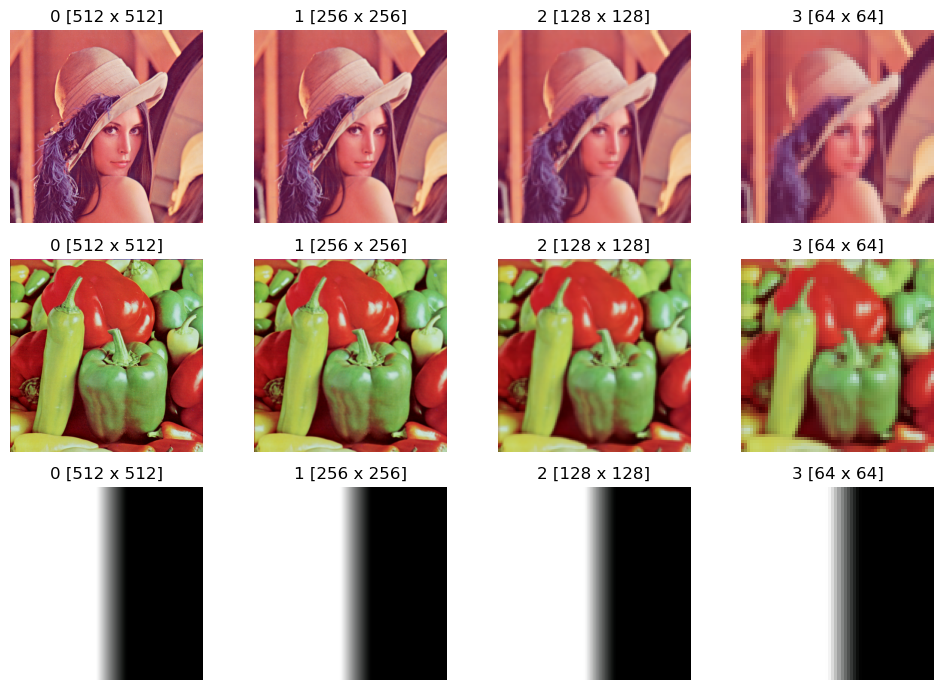

In [5]:
numLevels = 3
lennaGaussian = generate_gaussian_pyramid(lenna, numLevels)
peppersGaussian = generate_gaussian_pyramid(peppers, numLevels)
maskGaussian = generate_gaussian_pyramid(mask, numLevels)
plt.figure(figsize=(10, 7))

gaussianPyramids = [lennaGaussian, peppersGaussian, maskGaussian]

numRows = len(gaussianPyramids)
for k in range(0, len(gaussianPyramids), 1):
    pyramid = gaussianPyramids[k]
    numCols = len(pyramid)
    for i in range(0, numCols, 1):
        plt.subplot(numRows, numCols, (k * numCols) + i + 1)
        plt.title('%d [%d x %d]' % (i, pyramid[i].shape[0], pyramid[i].shape[1]))
        plt.imshow(pyramid[i])
        plt.axis('off')

plt.tight_layout()
plt.show()

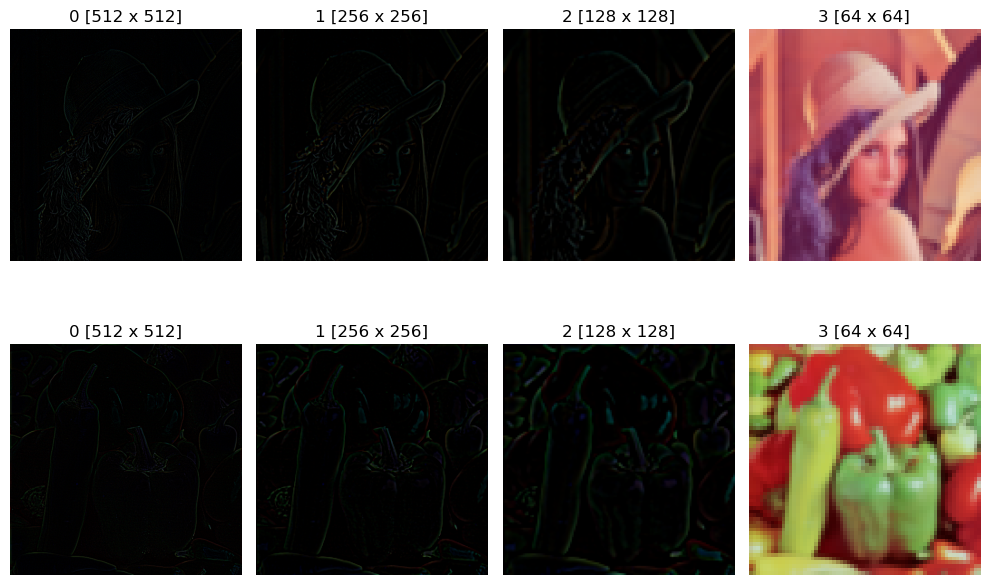

In [6]:
lennaLaplacian = generate_laplacian_pyramid(lennaGaussian)
peppersLaplacian = generate_laplacian_pyramid(peppersGaussian)
plt.figure(figsize=(10, 7))

laplacianPyramids = [lennaLaplacian, peppersLaplacian]
numRows = len(laplacianPyramids)

for k in range(0, len(laplacianPyramids), 1):
    pyramid = laplacianPyramids[k]
    numCols = len(pyramid)
    for i in range(0, numCols, 1):
        plt.subplot(numRows, numCols, (k * numCols) + i + 1)
        plt.title('%d [%d x %d]' % (i, pyramid[i].shape[0], pyramid[i].shape[1]))
        plt.imshow(pyramid[i])
        plt.axis('off')

plt.tight_layout()
plt.show()

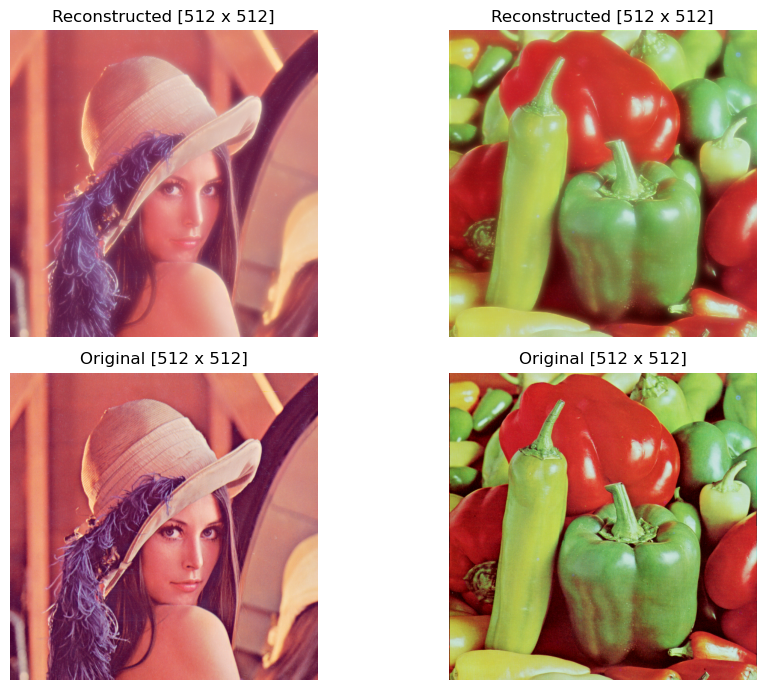

In [7]:
reconstructed = []
for k in range(0, len(laplacianPyramids), 1):
    reconstructed.append(reconstruct_from_pyramid(laplacianPyramids[k]))
plt.figure(figsize=(10, 7))
for i in range(0, len(reconstructed), 1):
    plt.subplot(2, len(reconstructed), i+1)
    plt.title('Reconstructed [%d x %d]' % (reconstructed[i].shape[0], reconstructed[i].shape[1]))
    plt.imshow(reconstructed[i])
    plt.axis('off')

origs = [lenna, peppers]
for i in range(0, len(origs), 1):
    plt.subplot(2, len(reconstructed), 3 + i)
    plt.title('Original [%d x %d]' % (origs[i].shape[0], origs[i].shape[1]))
    plt.imshow(origs[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

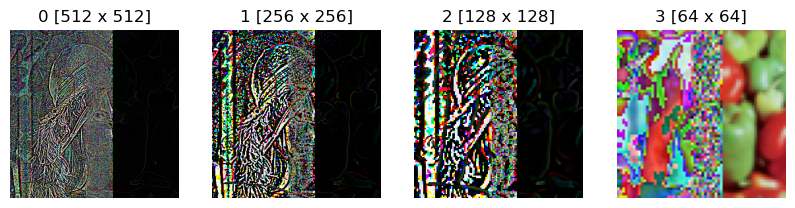

In [8]:
blended_pyramid = blend_pyramids(lennaLaplacian, peppersLaplacian, maskGaussian)
plt.figure(figsize=(10, 7))
for i in range(0, len(blended_pyramid), 1):
    plt.subplot(1, len(blended_pyramid), i + 1)
    plt.title('%d [%d x %d]' % (i, blended_pyramid[i].shape[0], blended_pyramid[i].shape[1]))
    plt.imshow(blended_pyramid[i])
    plt.axis('off')

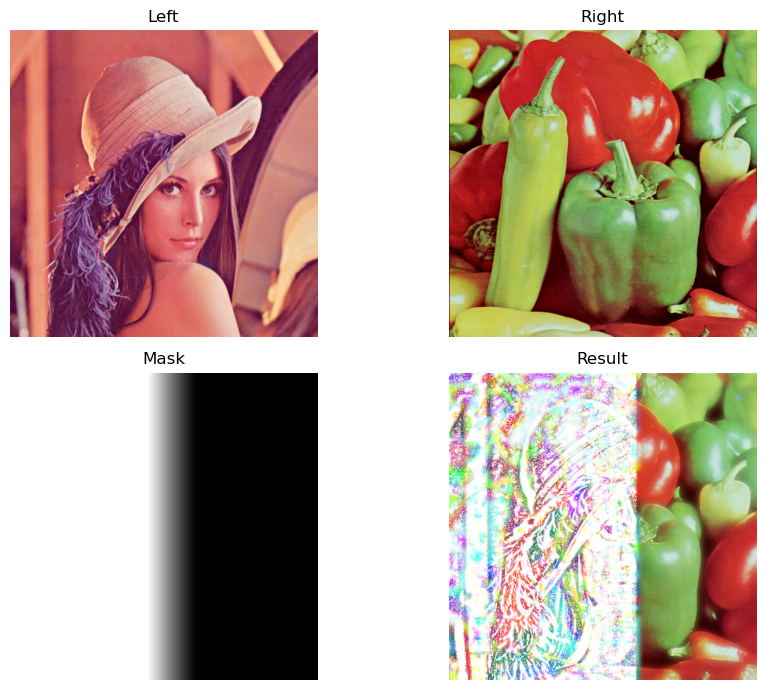

In [9]:
blended_image = reconstruct_from_pyramid(blended_pyramid)
plt.figure(figsize=(10, 7))

plt.subplot(2, 2, 1)
plt.title('Left')
plt.imshow(lenna)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Right')
plt.imshow(peppers)
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('Mask')
plt.imshow(mask)
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('Result')
plt.imshow(blended_image)
plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
result = laplacian_pyramid_blending(lenna, peppers, mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


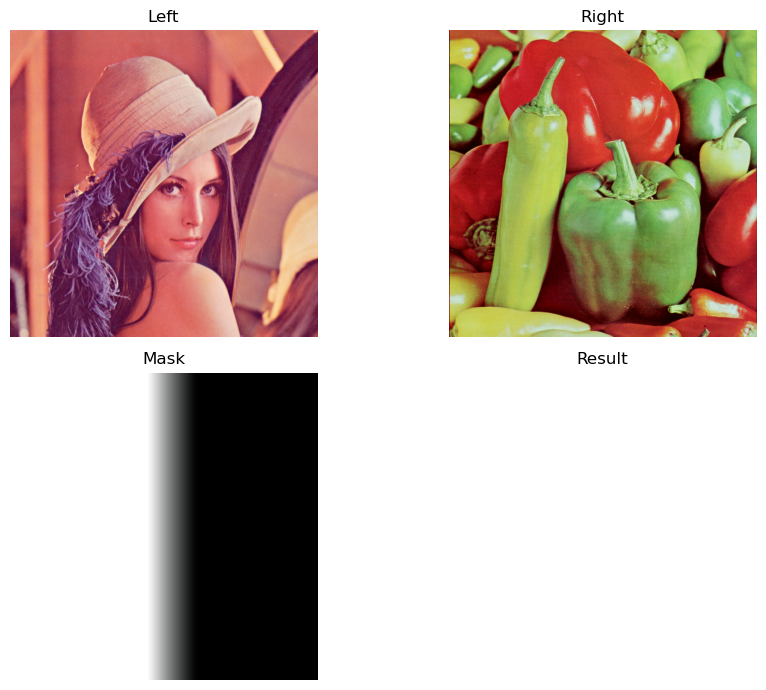

In [11]:
# Display the original and processed images
plt.figure(figsize=(10, 7))

plt.subplot(2, 2, 1)
plt.title('Left')
plt.imshow(lenna)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Right')
plt.imshow(peppers)
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('Mask')
plt.imshow(mask)
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('Result')
plt.imshow(result)
plt.axis('off')

plt.tight_layout()
plt.show()